## Price and Neighborhood

In [2]:
pip install --upgrade category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 69 kB 3.2 MB/s 


In [3]:
import warnings
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from category_encoders import OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge  # noqa F401
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.utils.validation import check_is_fitted

warnings.simplefilter(action="ignore", category=FutureWarning)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
def wrangle(filepath):
    # Read excel file
    df = pd.read_excel(filepath)

    # Subset data: Apartments in "Capital Federal", less than 400,000
    mask_ba = df["place_with_parent_names"].str.contains("Capital Federal")
    mask_apt = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 400_000
    df = df[mask_ba & mask_apt & mask_price]

    # Subset data: Remove outliers for "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]

    # Split "lat-lon" column
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
    df.drop(columns="lat-lon", inplace=True)
    
    # Extract neighborhood
    df["neighborhood"] = df["place_with_parent_names"].str.split("|", expand=True)[3]
    df.drop(columns="place_with_parent_names", inplace=True)

    return df

In [8]:
files = glob("/content/data_*.xlsx")
files

['/content/data_5.xlsx',
 '/content/data_3.xlsx',
 '/content/data_2.xlsx',
 '/content/data_4.xlsx',
 '/content/data_1.xlsx']

In [9]:
frames = []
for file in files:
    df = wrangle(file)
    frames.append(df)

In [10]:
frames[0].head()

,Unnamed: 0,operation,property_type,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,lat,lon,neighborhood
3,4,sell,apartment,112000.0,USD,1698188.80,112000.0,NaN,60.0,NaN,1866.666667,1.0,2.0,NaN,http://belgrano.properati.com.ar/116pr_venta_d...,-34.564676,-58.455720,Belgrano
9,10,sell,apartment,76500.0,USD,1159923.60,76500.0,0.0,36.0,NaN,2125.000000,NaN,2.0,1000.0,http://caballito.properati.com.ar/12ksf_venta_...,-34.618830,-58.437779,Caballito
18,19,sell,apartment,90000.0,USD,1364616.00,90000.0,100.0,100.0,900.000000,900.000000,NaN,3.0,NaN,http://belgrano.properati.com.ar/zouu_venta_de...,-34.577168,-58.538654,Belgrano
20,21,sell,apartment,159900.0,USD,2424467.76,159900.0,82.0,77.0,1950.000000,2076.623377,NaN,3.0,NaN,http://colegiales.properati.com.ar/zpcd_venta_...,-34.571526,-58.455637,Colegiales
21,22,sell,apartment,123875.0,USD,1878242.30,123875.0,79.0,50.0,1568.037975,2477.500000,NaN,2.0,NaN,http://colegiales.properati.com.ar/12sbf_venta...,-34.578688,-58.457358,Colegiales


In [11]:
df = pd.concat(frames, ignore_index=True)
df.shape

(6582, 18)

In [12]:
df.head()

,Unnamed: 0,operation,property_type,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,lat,lon,neighborhood
0,4,sell,apartment,112000.0,USD,1698188.80,112000.0,NaN,60.0,NaN,1866.666667,1.0,2.0,NaN,http://belgrano.properati.com.ar/116pr_venta_d...,-34.564676,-58.455720,Belgrano
1,10,sell,apartment,76500.0,USD,1159923.60,76500.0,0.0,36.0,NaN,2125.000000,NaN,2.0,1000.0,http://caballito.properati.com.ar/12ksf_venta_...,-34.618830,-58.437779,Caballito
2,19,sell,apartment,90000.0,USD,1364616.00,90000.0,100.0,100.0,900.000000,900.000000,NaN,3.0,NaN,http://belgrano.properati.com.ar/zouu_venta_de...,-34.577168,-58.538654,Belgrano
3,21,sell,apartment,159900.0,USD,2424467.76,159900.0,82.0,77.0,1950.000000,2076.623377,NaN,3.0,NaN,http://colegiales.properati.com.ar/zpcd_venta_...,-34.571526,-58.455637,Colegiales
4,22,sell,apartment,123875.0,USD,1878242.30,123875.0,79.0,50.0,1568.037975,2477.500000,NaN,2.0,NaN,http://colegiales.properati.com.ar/12sbf_venta...,-34.578688,-58.457358,Colegiales


In [13]:
target = "price_aprox_usd"
features = ["neighborhood"]
y_train = df[target]
X_train =df[features]

In [14]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean]*len(y_train)
print("Mean apt price:", y_mean)

print("Baseline MAE:", mean_absolute_error(y_train, y_pred_baseline))

Mean apt price: 132383.83701458524
Baseline MAE: 44860.10834274133


In [15]:
X_train.head()

,neighborhood
0,Belgrano
1,Caballito
2,Belgrano
3,Colegiales
4,Colegiales


In [16]:
# Instantiate
ohe = OneHotEncoder(use_cat_names=True)

# Fit
ohe.fit(X_train)

# Transform
XT_train = ohe.transform(X_train)
print(XT_train.shape)
XT_train.head()

(6582, 57)


,neighborhood_Belgrano,neighborhood_Caballito,neighborhood_Colegiales,neighborhood_Almagro,neighborhood_Palermo,neighborhood_Saavedra,neighborhood_Once,neighborhood_Congreso,neighborhood_Balvanera,neighborhood_Villa Crespo,...,neighborhood_Abasto,neighborhood_Villa General Mitre,neighborhood_Las Cañitas,neighborhood_Tribunales,neighborhood_Monte Castro,neighborhood_Villa Soldati,neighborhood_Parque Chas,neighborhood_Velez Sarsfield,neighborhood_Villa Real,neighborhood_Catalinas
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    Ridge()
)

model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['neighborhood'], use_cat_names=True)),
                ('ridge', Ridge())])

In [18]:
check_is_fitted(model[-1])

In [19]:
y_pred_training = model.predict(X_train)
mae_training = mean_absolute_error(y_train, y_pred_training)
print("Training MAE:", round(mae_training, 2))

Training MAE: 39350.22


In [22]:
X_test = pd.read_excel("/content/features.xlsx")[features]
y_pred_test = pd.Series(model.predict(X_test))
y_pred_test.head()

0    246624.694624
1    161355.968734
2     98232.051308
3    110846.030377
4    127777.538197
dtype: float64

In [23]:
intercept = model.named_steps["ridge"].intercept_
coefficients = model.named_steps["ridge"].coef_
print("coefficients len:", len(coefficients))
print(coefficients[:5])  # First five coefficients

coefficients len: 57
[46954.20800905  9252.89087596 38436.32790329  2903.33556626
 45934.4105851 ]


In [24]:
feature_names = model.named_steps['onehotencoder'].get_feature_names()
print("features len:", len(feature_names))
print(feature_names[:5])  # First five feature names

features len: 57
['neighborhood_Belgrano', 'neighborhood_Caballito', 'neighborhood_Colegiales', 'neighborhood_Almagro', 'neighborhood_Palermo']


In [25]:
feat_imp = pd.Series(coefficients, index=feature_names)
feat_imp.head()

neighborhood_Belgrano      46954.208009
neighborhood_Caballito      9252.890876
neighborhood_Colegiales    38436.327903
neighborhood_Almagro        2903.335566
neighborhood_Palermo       45934.410585
dtype: float64

In [26]:
print(f"price = {intercept.round(2)}")
for f, c in feat_imp.items():
    print(f"+ ({round(c, 2)} * {f})")

price = 118524.65
+ (46954.21 * neighborhood_Belgrano)
+ (9252.89 * neighborhood_Caballito)
+ (38436.33 * neighborhood_Colegiales)
+ (2903.34 * neighborhood_Almagro)
+ (45934.41 * neighborhood_Palermo)
+ (14701.16 * neighborhood_Saavedra)
+ (-3230.37 * neighborhood_Once)
+ (-7974.66 * neighborhood_Congreso)
+ (-11172.55 * neighborhood_Balvanera)
+ (6277.05 * neighborhood_Villa Crespo)
+ (-8662.28 * neighborhood_Flores)
+ (5638.47 * neighborhood_San Telmo)
+ (-19370.74 * neighborhood_)
+ (-8093.45 * neighborhood_Villa Pueyrredón)
+ (-4618.66 * neighborhood_Barracas)
+ (55590.93 * neighborhood_Barrio Norte)
+ (27042.61 * neighborhood_Retiro)
+ (-6837.4 * neighborhood_Boedo)
+ (12671.71 * neighborhood_Villa Urquiza)
+ (-11208.9 * neighborhood_Villa Ortuzar)
+ (-43909.59 * neighborhood_Pompeya)
+ (-41748.73 * neighborhood_Constitución)
+ (12223.11 * neighborhood_Coghlan)
+ (-12595.5 * neighborhood_Villa del Parque)
+ (-7678.62 * neighborhood_Parque Chacabuco)
+ (72740.78 * neighborhood_Rec

Text(0.5, 1.0, 'Feature Importance for Apartment Price ')

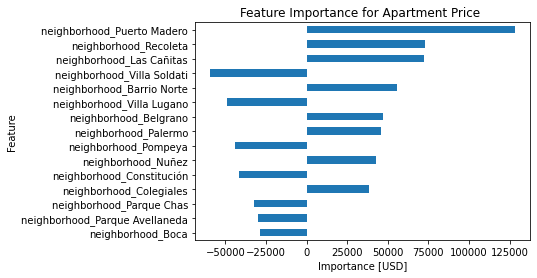

In [27]:
feat_imp.sort_values(key=abs).tail(15).plot(kind="barh")
plt.xlabel("Importance [USD]")
plt.ylabel("Feature")
plt.title("Feature Importance for Apartment Price ")